# Adjust Window Size

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Initialize Sensor and Functions

In [2]:
# Import Libraries
import smbus
from sched import scheduler
from time import time
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
from scipy.signal import medfilt
import allantools

# Register Values
PWR_MGMT_1   = 0x6B
SMPLRT_DIV   = 0x19
CONFIG       = 0x1A
GYRO_CONFIG  = 0x1B
ACCEL_CONFIG = 0x1C
INT_ENABLE   = 0x38
ACCEL_XOUT_H = 0x3B
ACCEL_YOUT_H = 0x3D
ACCEL_ZOUT_H = 0x3F
GYRO_XOUT_H  = 0x43
GYRO_YOUT_H  = 0x45
GYRO_ZOUT_H  = 0x47
TEMP_OUT_H   = 0x41

# Constant Value
GRAV_CONST   = 9.8
ACCEL_CONST  = 2048
GRYO_CONST   = 131.0
TEMP_CONST   = 340.0

# Calibration Values
calibration = dict()
calibration['Offset_Ac_X'] = 0.0181884765625
calibration['Offset_Ac_Y'] = -7.324218750004441e-05
calibration['Offset_Ac_Z'] = 0.10261230468749999
calibration['Scale_Ac_X'] = 0.9986083984375
calibration['Scale_Ac_Y'] = 1.0138427734375
calibration['Scale_Ac_Z'] = -1.0182373046875
calibration['Offset_Gy_X'] = -2.4717557251908397
calibration['Offset_Gy_Y'] = -0.333587786259542
calibration['Offset_Gy_Z'] = -2.2610687022900766

def MPU_Init():
    # Write to sample rate register
    bus.write_byte_data(Device_Address, SMPLRT_DIV, 7)

    # Write to power management register
    bus.write_byte_data(Device_Address, PWR_MGMT_1, 1)
    
    # Write to Configuration register
    bus.write_byte_data(Device_Address, CONFIG, 0)

    # Write to Gyro configuration register
    bus.write_byte_data(Device_Address, GYRO_CONFIG, 0)

    # Write to Accel configuration register
    bus.write_byte_data(Device_Address, ACCEL_CONFIG, 24)

    # Write to interrupt enable register
    bus.write_byte_data(Device_Address, INT_ENABLE, 1)
    
def read_raw_data(addr):
    # Accelerometer and Gyrometer value are 16-bit
    high = bus.read_byte_data(Device_Address, addr)
    low = bus.read_byte_data(Device_Address, addr+1)

    # Concatenate higher and lower value
    value = ((high << 8) | low)

    # to get signed value from mpu6050
    if(value > 32768):
        value = value - 65536
    return value

def read_accel():
    ac_x = ((((read_raw_data(ACCEL_XOUT_H)/ACCEL_CONST)) - calibration['Offset_Ac_X']) * calibration['Scale_Ac_X'])
    ac_y = ((((read_raw_data(ACCEL_YOUT_H)/ACCEL_CONST)) - calibration['Offset_Ac_Y']) * calibration['Scale_Ac_Y'])
    ac_z = ((((read_raw_data(ACCEL_ZOUT_H)/ACCEL_CONST)) - calibration['Offset_Ac_Z']) * calibration['Scale_Ac_Z']) + 1 # Uncomment to zero Z-axis
    
    # Convert g to m/s
    ac_x = ac_x * GRAV_CONST
    ac_y = ac_y * GRAV_CONST
    ac_z = ac_z * GRAV_CONST
    
    return ac_x, ac_y, ac_z

def read_gyro():
    gy_x = (read_raw_data(GYRO_XOUT_H)/GRYO_CONST) - calibration['Offset_Gy_X']
    gy_y = (read_raw_data(GYRO_YOUT_H)/GRYO_CONST) - calibration['Offset_Gy_Y']
    gy_z = (read_raw_data(GYRO_ZOUT_H)/GRYO_CONST) - calibration['Offset_Gy_Z']
    
    return gy_x, gy_y, gy_z
    
def read_temp():
    return (read_raw_data(TEMP_OUT_H)/TEMP_CONST) + 36.53

def accel_sample_average(addr, sample_size = 10):    
    accel_val = []
    for i in range(sample_size):
        accel_val.append((read_raw_data(addr)/ACCEL_CONST))
        
    return np.average(accel_val)

def gyro_sample_average(addr, sample_size = 10):
    gyro_val = []
    for i in range(sample_size):
        gyro_val.append(read_raw_data(addr)/GRYO_CONST)
        
    return np.average(gyro_val)

def calc_vel(init_vel, accel, time_delta):
    return init_vel + (accel * time_delta)

def calc_pos(init_pos, init_vel, accel, time_delta):
    return init_pos + (init_vel * time_delta) + (0.5 * accel * (time_delta ** 2))

def calc_angle(init_ang, avel, time_delta):
    return init_ang + (avel * time_delta)

bus = smbus.SMBus(1) 	# or bus = smbus.SMBus(0) for older version boards
Device_Address = 0x68   # MPU6050 device address
MPU_Init()

# Acceleration Calibration
X-axis Down

In [4]:
x_min = accel_sample_average(ACCEL_XOUT_H)

X-axis Up

In [5]:
x_max = accel_sample_average(ACCEL_XOUT_H)

Y-axis Down

In [8]:
y_min = accel_sample_average(ACCEL_YOUT_H)

Y-axis Up

In [9]:
y_max = accel_sample_average(ACCEL_YOUT_H)

Z-axis Down

In [12]:
z_min = accel_sample_average(ACCEL_ZOUT_H)

Z-axis Up

In [13]:
z_max = accel_sample_average(ACCEL_ZOUT_H)

Calculate Offset and Scale

In [14]:
calibration['Offset_Ac_X'] = (x_min + x_max) / 2
calibration['Offset_Ac_Y'] = (y_min + y_max) / 2
calibration['Offset_Ac_Z'] = (z_min + z_max) / 2
calibration['Scale_Ac_X'] = x_max - calibration['Offset_Ac_X']
calibration['Scale_Ac_Y'] = y_max - calibration['Offset_Ac_Y']
calibration['Scale_Ac_Z'] = z_max - calibration['Offset_Ac_Z']

print("X Offset:\t" + str(calibration['Offset_Ac_X']))
print("Y Offset:\t" + str(calibration['Offset_Ac_Y']))
print("Z Offset:\t" + str(calibration['Offset_Ac_Z']))

print("X Scale:\t" + str(calibration['Scale_Ac_X']))
print("Y Scale:\t" + str(calibration['Scale_Ac_Y']))
print("Z Scale:\t" + str(calibration['Scale_Ac_Z']))

X Offset:	-0.383251953125
Y Offset:	-0.5693359375
Z Offset:	1.518505859375
X Scale:	0.3626953125
Y Scale:	0.20737304687500002
Z Scale:	0.18486328124999996


# Gyroscope Calibration

In [15]:
calibration['Offset_Gy_X'] = gyro_sample_average(GYRO_XOUT_H)
calibration['Offset_Gy_Y'] = gyro_sample_average(GYRO_YOUT_H)
calibration['Offset_Gy_Z'] = gyro_sample_average(GYRO_ZOUT_H)

print("X Offset:\t" + str(calibration['Offset_Gy_X']))
print("Y Offset:\t" + str(calibration['Offset_Gy_Y']))
print("Z Offset:\t" + str(calibration['Offset_Gy_Z']))

X Offset:	132.59541984732823
Y Offset:	-25.824427480916036
Z Offset:	-3.2297709923664124


# Data Reading

In [10]:
# TESTING CONSTANTS
SAMPLE_AMOUNT = 100
PRINT = True

# Sample Time (s)
SAMPLE_TIME = 0.1

# Data Array Dictionary
data = dict()
data['Accelerometer'] = dict()
data['Accelerometer']['Acceleration'] = dict()
data['Accelerometer']['Velocity'] = dict()
data['Accelerometer']['Position'] = dict()
data['Gyroscope'] = dict()
data['Gyroscope']['Angular Velocity'] = dict()
data['Gyroscope']['Angle'] = dict()

data['Time'] = []
data['Accelerometer']['Acceleration']['X'] = []
data['Accelerometer']['Acceleration']['Y'] = []
data['Accelerometer']['Acceleration']['Z'] = []
data['Accelerometer']['Velocity']['X'] = []
data['Accelerometer']['Velocity']['Y'] = []
data['Accelerometer']['Velocity']['Z'] = []
data['Accelerometer']['Position']['X'] = []
data['Accelerometer']['Position']['Y'] = []
data['Accelerometer']['Position']['Z'] = []
data['Gyroscope']['Angular Velocity']['X'] = []
data['Gyroscope']['Angular Velocity']['Y'] = []
data['Gyroscope']['Angular Velocity']['Z'] = []
data['Gyroscope']['Angle']['X'] = []
data['Gyroscope']['Angle']['Y'] = []
data['Gyroscope']['Angle']['Z'] = []
data['Temperature'] = []

def smooth_data(prev_data, data, history=50):
    return medfilt(prev_data[-history:] + [data], kernel_size=1)[-1]

# Read Data Function
def read_data():
    global prev_time
    global prev_vel_x
    global prev_vel_y
    global prev_vel_z
    global prev_pos_x
    global prev_pos_y
    global prev_pos_z
    global prev_ang_x
    global prev_ang_y
    global prev_ang_z
    
    # Read Data
    curr_time = time()
    accel_x, accel_y, accel_z = read_accel()
    avel_x, avel_y, avel_z = read_gyro()
    temp = read_temp()
    
    # Smooth Data
    accel_x = smooth_data(data['Accelerometer']['Acceleration']['X'], accel_x)
    accel_y = smooth_data(data['Accelerometer']['Acceleration']['Y'], accel_y)
    accel_z = smooth_data(data['Accelerometer']['Acceleration']['Z'], accel_z)
    avel_x = smooth_data(data['Gyroscope']['Angular Velocity']['X'], avel_x)
    avel_y = smooth_data(data['Gyroscope']['Angular Velocity']['Y'], avel_y)
    avel_z = smooth_data(data['Gyroscope']['Angular Velocity']['Z'], avel_z)
    
    # Calculate Data
    time_delta = curr_time - prev_time
    vel_x = calc_vel(prev_vel_x, accel_x, time_delta)
    vel_y = calc_vel(prev_vel_y, accel_y, time_delta)
    vel_z = calc_vel(prev_vel_z, accel_z, time_delta)
    pos_x = calc_pos(prev_pos_x, prev_vel_x, accel_x, time_delta)
    pos_y = calc_pos(prev_pos_y, prev_vel_y, accel_y, time_delta)
    pos_z = calc_pos(prev_pos_z, prev_vel_z, accel_z, time_delta)
    ang_x = calc_angle(prev_ang_x, avel_x, time_delta)
    ang_y = calc_angle(prev_ang_y, avel_y, time_delta)
    ang_z = calc_angle(prev_ang_z, avel_z, time_delta)
    
    # Update Previous Data
    prev_time = curr_time
    prev_vel_x = vel_x
    prev_vel_y = vel_y
    prev_vel_z = vel_z
    prev_pos_x = pos_x
    prev_pos_y = pos_y
    prev_pos_z = pos_z
    prev_ang_x = ang_x
    prev_ang_y = ang_y
    prev_ang_z = ang_z
    
    if PRINT:
        print(("{: ^15.5f}|" * 17).format(time_delta, accel_x, accel_y, accel_z, vel_x, vel_y, vel_z, pos_x, pos_y, pos_z, avel_x, avel_y, avel_z, ang_x, ang_y, ang_z, temp))

    data['Time'].append(curr_time)
    data['Accelerometer']['Acceleration']['X'].append(accel_x)
    data['Accelerometer']['Acceleration']['Y'].append(accel_y)
    data['Accelerometer']['Acceleration']['Z'].append(accel_z)
    data['Accelerometer']['Velocity']['X'].append(vel_x)
    data['Accelerometer']['Velocity']['Y'].append(vel_y)
    data['Accelerometer']['Velocity']['Z'].append(vel_z)
    data['Accelerometer']['Position']['X'].append(pos_x)
    data['Accelerometer']['Position']['Y'].append(pos_y)
    data['Accelerometer']['Position']['Z'].append(pos_z)
    data['Gyroscope']['Angular Velocity']['X'].append(avel_x)
    data['Gyroscope']['Angular Velocity']['Y'].append(avel_y)
    data['Gyroscope']['Angular Velocity']['Z'].append(avel_z)
    data['Gyroscope']['Angle']['X'].append(ang_x)
    data['Gyroscope']['Angle']['Y'].append(ang_y)
    data['Gyroscope']['Angle']['Z'].append(ang_z)
    data['Temperature'].append(temp)
    
# Initialize Scheduler
s = scheduler(time, sleep)

# Setup Event
def event(countdown):
    if ((countdown > 0)):
        read_data()
        s.enter(SAMPLE_TIME, 1, event, argument=(countdown - 1,))
        s.run()
    elif (countdown < 0):
        read_data()
        s.enter(SAMPLE_TIME, 1, event, argument=(countdown,))
        s.run()

# Initialize Variables
initial_time = time()
prev_time = initial_time
prev_vel_x = 0
prev_vel_y = 0
prev_vel_z = 0
prev_pos_x = 0
prev_pos_y = 0
prev_pos_z = 0
prev_ang_x = 0
prev_ang_y = 0
prev_ang_z = 0
        
# Start Sampling
if PRINT:
    print(("{:^15}|" * 17).format("TIME (s)", "X ACCEL (m/s^2)", "Y ACCEL (m/s^2)", "Z ACCEL (m/s^2)",
                                     "X VEL (m/s)", "Y VEL (m/s)", "Z VEL (m/s)",
                                     "X POS (m)", "Y POS (m)", "Z POS (m)",
                                     "X ANG VEL (\u00b0/s)", "Y ANG VEL (\u00b0/s)", "Z ANG VEL (\u00b0/s)",
                                     "X ANG (\u00b0)", "Y ANG (\u00b0)", "Z ANG (\u00b0)",
                                     "TEMP (\u00b0C)"))

read_data()
s.enter(SAMPLE_TIME, 1, event, argument=(SAMPLE_AMOUNT,))
s.run()
print("COMPLETED")

   TIME (s)    |X ACCEL (m/s^2)|Y ACCEL (m/s^2)|Z ACCEL (m/s^2)|  X VEL (m/s)  |  Y VEL (m/s)  |  Z VEL (m/s)  |   X POS (m)   |   Y POS (m)   |   Z POS (m)   |X ANG VEL (°/s)|Y ANG VEL (°/s)|Z ANG VEL (°/s)|   X ANG (°)   |   Y ANG (°)   |   Z ANG (°)   |   TEMP (°C)   |
    0.00237    |   -0.20667    |   -0.09145    |   -0.32417    |   -0.00049    |   -0.00022    |   -0.00077    |   -0.00000    |   -0.00000    |   -0.00000    |   -0.06260    |   -0.00229    |   -0.07481    |   -0.00015    |   -0.00001    |   -0.00018    |   28.20059    |
    0.11005    |   -0.22101    |   -0.00898    |   -0.36315    |   -0.02481    |   -0.00120    |   -0.04073    |   -0.00139    |   -0.00008    |   -0.00228    |   -0.13130    |   -0.00229    |    0.15420    |   -0.01460    |   -0.00026    |    0.01679    |   26.78882    |
    0.10923    |   -0.16844    |    1.22328    |   -0.29493    |   -0.04321    |    0.13242    |   -0.07295    |   -0.00511    |    0.00709    |   -0.00849    |    0.05191    |   -0

    0.11306    |   -0.21145    |    0.01528    |   -0.23646    |   -0.67429    |   -0.10232    |   -1.05065    |   -1.26192    |    0.03630    |   -1.91530    |    0.11298    |    0.03588    |    0.10076    |   -0.02388    |    0.00076    |    0.52545    |   27.44765    |
    0.11475    |   -0.18756    |   -0.02838    |   -0.23159    |   -0.69582    |   -0.10558    |   -1.07722    |   -1.34053    |    0.02438    |   -2.03739    |   -0.02443    |   -0.01756    |    0.16947    |   -0.02668    |   -0.00126    |    0.54489    |   27.54176    |
    0.11313    |   -0.25445    |    0.00558    |   -0.28519    |   -0.72460    |   -0.10494    |   -1.10949    |   -1.42088    |    0.01247    |   -2.16108    |   -0.01679    |    0.05878    |    0.16947    |   -0.02858    |    0.00539    |    0.56407    |   27.44765    |
    0.11484    |   -1.38218    |   -0.05749    |    0.84521    |   -0.88333    |   -0.11155    |   -1.01242    |   -1.51321    |    0.00004    |   -2.28292    |    0.00611    |   -0

    0.11643    |   -0.20189    |   -0.02838    |   -0.36315    |   -1.44207    |   -0.20563    |   -1.78938    |   -5.51834    |   -0.73164    |   -7.22530    |    0.12061    |   -0.07099    |    0.09313    |   -0.12522    |   -0.06046    |    0.63700    |   27.54176    |
    0.11695    |   -0.18756    |   -0.07204    |   -0.38751    |   -1.46401    |   -0.21406    |   -1.83470    |   -5.68827    |   -0.75618    |   -7.43721    |    0.02137    |    0.08931    |    0.30687    |   -0.12272    |   -0.05002    |    0.67289    |   27.54176    |
    0.11483    |   -0.24012    |   -0.03323    |   -0.25108    |   -1.49158    |   -0.21788    |   -1.86353    |   -5.85796    |   -0.78098    |   -7.64954    |   -0.05496    |   -0.00229    |    0.19237    |   -0.12903    |   -0.05028    |    0.69497    |   27.54176    |
    0.11704    |   -0.13021    |   -0.03808    |   -0.30955    |   -1.50682    |   -0.22233    |   -1.89976    |   -6.03343    |   -0.80674    |   -7.86977    |    0.05954    |   -0

    0.11512    |   -0.18278    |   -0.02353    |   -0.31442    |   -2.08185    |   -0.02783    |   -2.82529    |   -12.16413   |   -0.82502    |   -15.85577   |   -0.05496    |   -0.01756    |    0.05496    |   -0.15526    |   -0.04847    |    1.16532    |   28.20059    |
    0.11511    |   -0.19711    |   -0.07204    |    0.75264    |   -2.10454    |   -0.03612    |   -2.73866    |   -12.40507   |   -0.82871    |   -16.17600   |    0.02901    |   -0.15496    |    0.13130    |   -0.15193    |   -0.06631    |    1.18044    |   26.78882    |
    0.11355    |   -0.16366    |    0.06865    |   -0.35827    |   -2.12312    |   -0.02833    |   -2.77934    |   -12.64509   |   -0.83236    |   -16.48927   |   -0.08550    |   -0.02519    |    0.20000    |   -0.16163    |   -0.06917    |    1.20315    |   27.54176    |
    0.11519    |   -0.16844    |   -0.07689    |   -0.26570    |   -2.14253    |   -0.03719    |   -2.80995    |   -12.89078   |   -0.83614    |   -16.81119   |    0.03664    |    0

# Data Plotting

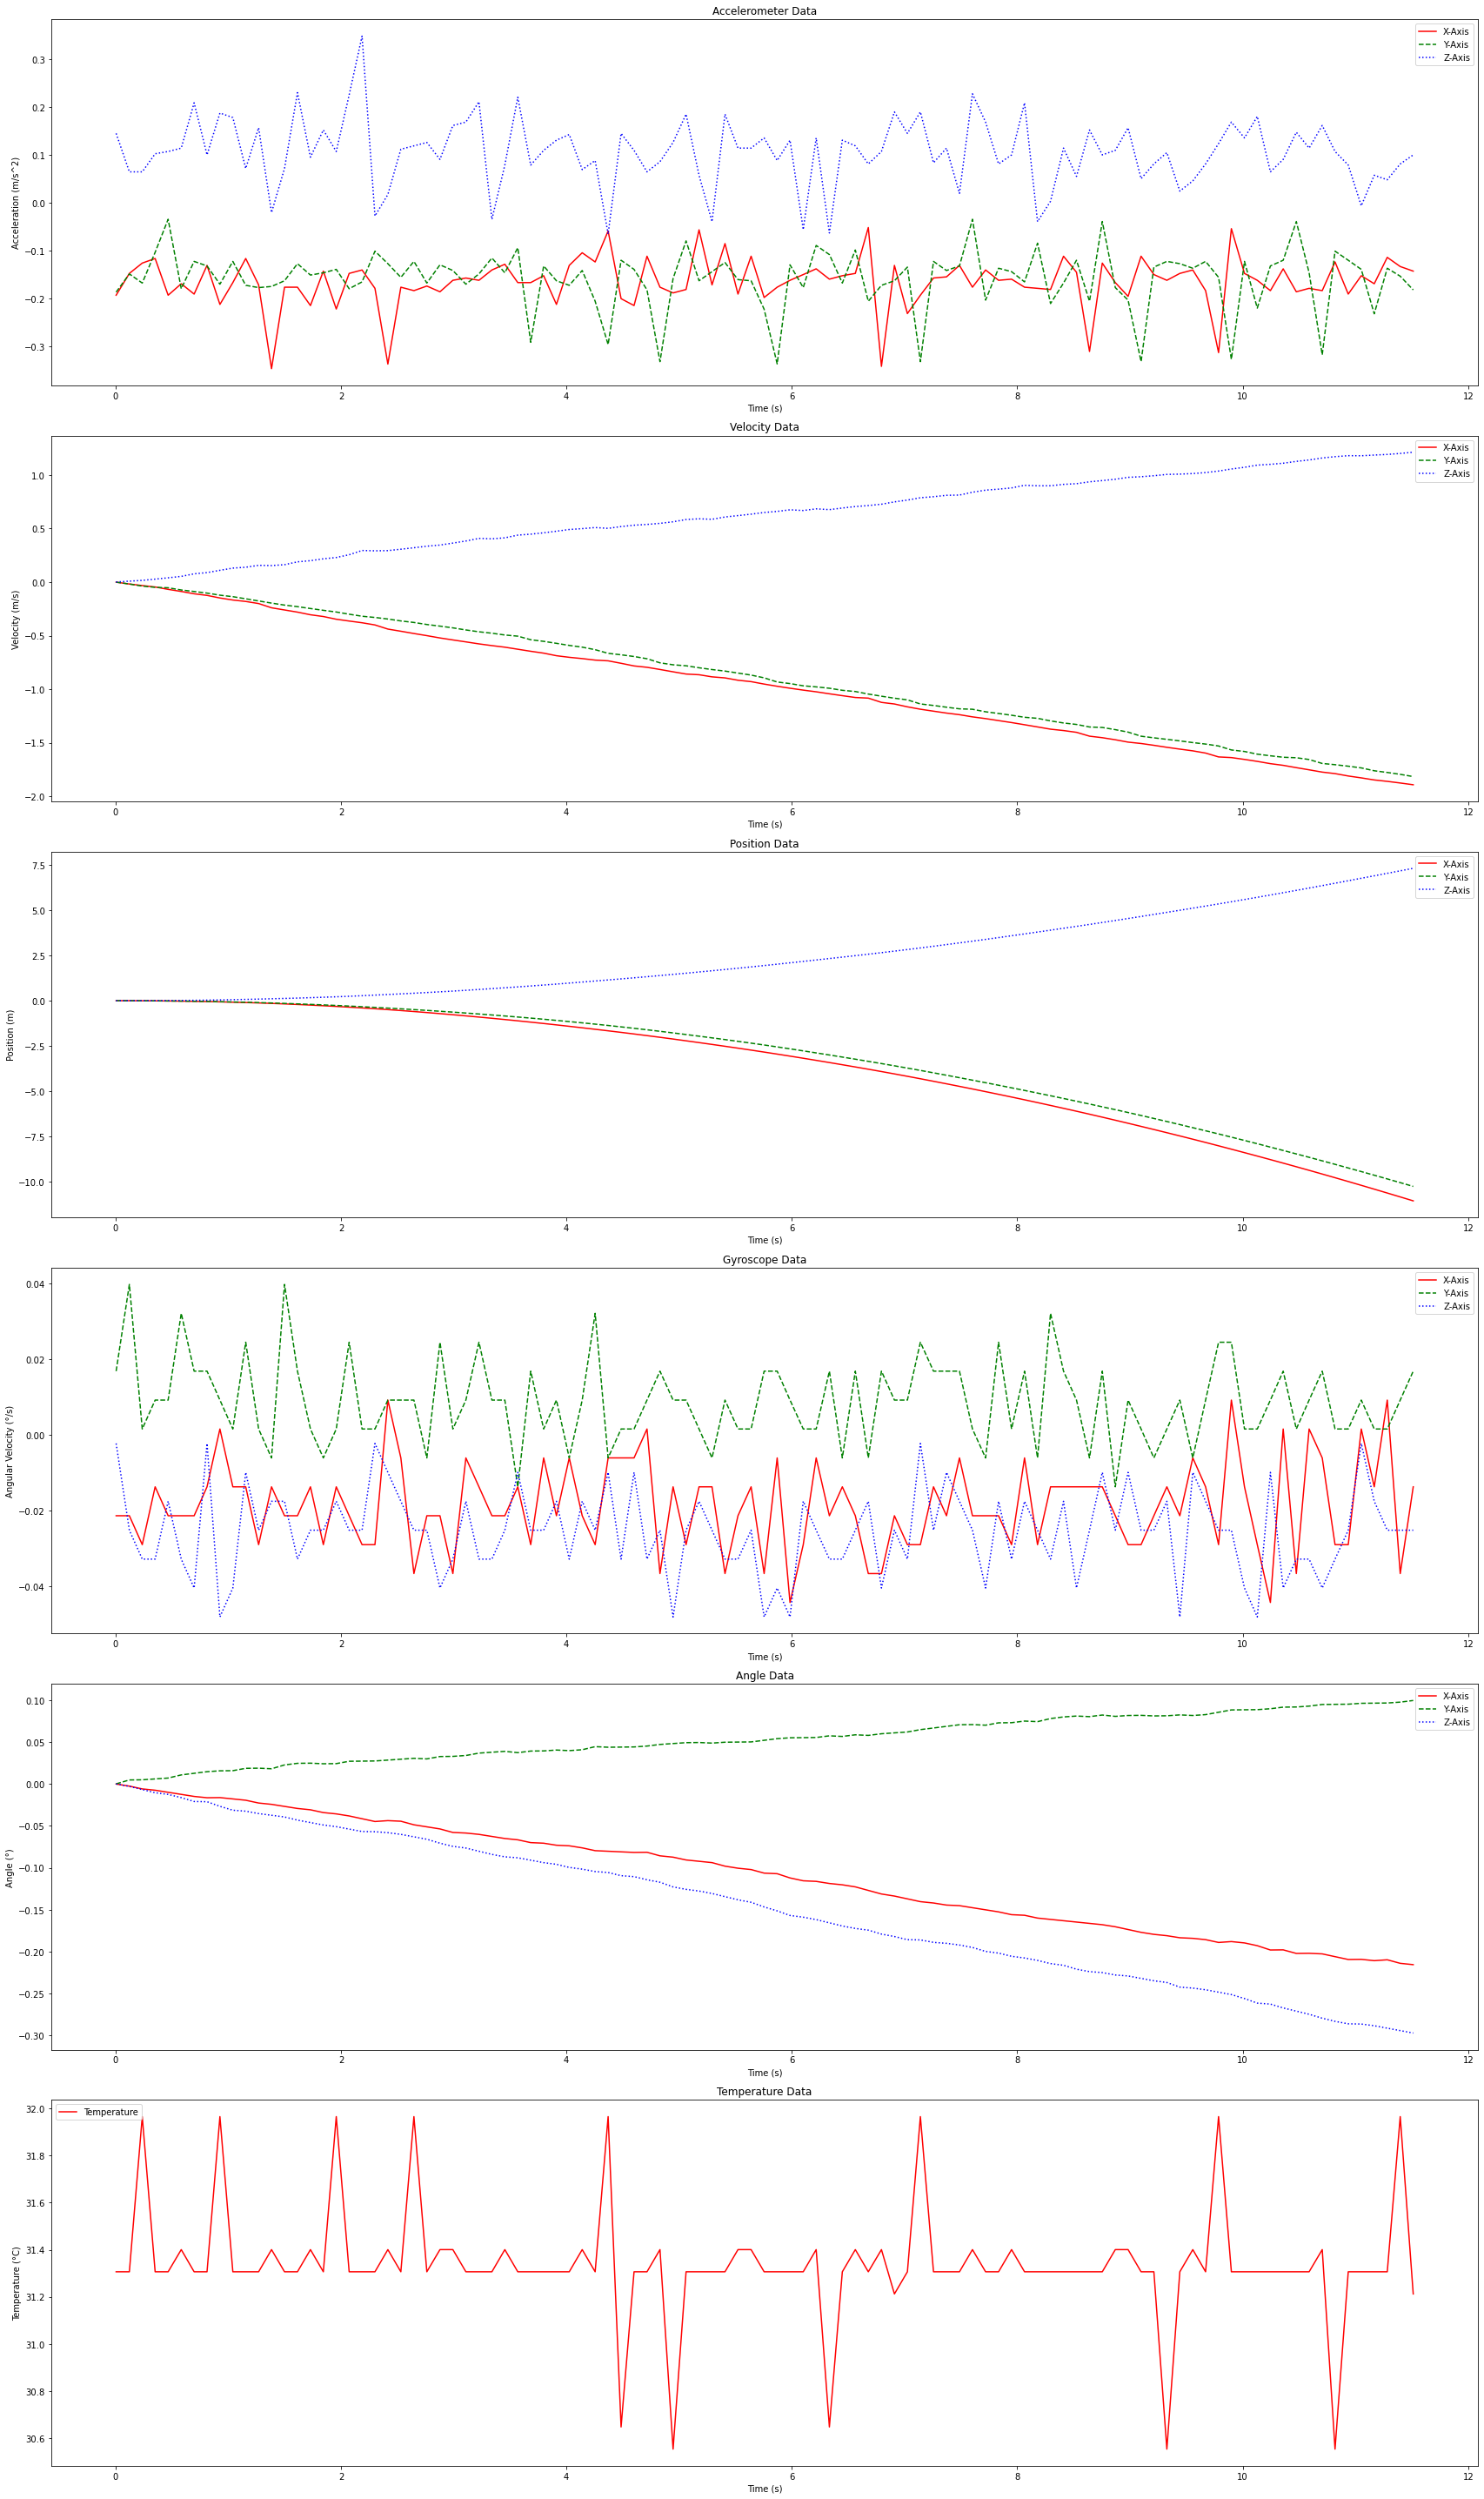

In [125]:
%matplotlib inline

# Set figure size
plt.rcParams['figure.figsize'] = [23.8, 40]
plt.rcParams["figure.autolayout"] = True

# Create figure
plt.figure()

# Calculate time delta
time_delta = np.subtract(data['Time'], initial_time)

# Plot acceleration data
plt.subplot(611)
plt.title("Accelerometer Data")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.plot(time_delta, data['Accelerometer']['Acceleration']['X'], 'r-', label="X-Axis")
plt.plot(time_delta, data['Accelerometer']['Acceleration']['Y'], 'g--', label="Y-Axis")
plt.plot(time_delta, data['Accelerometer']['Acceleration']['Z'], 'b:', label="Z-Axis")
plt.legend()

# Plot velocity data
plt.subplot(612)
plt.title("Velocity Data")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.plot(time_delta, data['Accelerometer']['Velocity']['X'], 'r-', label="X-Axis")
plt.plot(time_delta, data['Accelerometer']['Velocity']['Y'], 'g--', label="Y-Axis")
plt.plot(time_delta, data['Accelerometer']['Velocity']['Z'], 'b:', label="Z-Axis")
plt.legend()

# Plot position data
plt.subplot(613)
plt.title("Position Data")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.plot(time_delta, data['Accelerometer']['Position']['X'], 'r-', label="X-Axis")
plt.plot(time_delta, data['Accelerometer']['Position']['Y'], 'g--', label="Y-Axis")
plt.plot(time_delta, data['Accelerometer']['Position']['Z'], 'b:', label="Z-Axis")
plt.legend()

# Plot gyroscope data
plt.subplot(614)
plt.title("Gyroscope Data")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (\u00b0/s)")
plt.plot(time_delta, data['Gyroscope']['Angular Velocity']['X'], 'r-', label="X-Axis")
plt.plot(time_delta, data['Gyroscope']['Angular Velocity']['Y'], 'g--', label="Y-Axis")
plt.plot(time_delta, data['Gyroscope']['Angular Velocity']['Z'], 'b:', label="Z-Axis")
plt.legend()

# Plot angle data
plt.subplot(615)
plt.title("Angle Data")
plt.xlabel("Time (s)")
plt.ylabel("Angle (\u00b0)")
plt.plot(time_delta, data['Gyroscope']['Angle']['X'], 'r-', label="X-Axis")
plt.plot(time_delta, data['Gyroscope']['Angle']['Y'], 'g--', label="Y-Axis")
plt.plot(time_delta, data['Gyroscope']['Angle']['Z'], 'b:', label="Z-Axis")
plt.legend()

# Plot temperature data
plt.subplot(616)
plt.title("Temperature Data")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (\u00b0C)")
plt.plot(time_delta, data['Temperature'], 'r', label="Temperature")
plt.legend()

# Static Error Calculation

In [18]:
error = dict()
error['Standard Deviation'] = dict()
error['Standard Deviation']['Acceleration'] = dict()
error['Standard Deviation']['Velocity'] = dict()
error['Standard Deviation']['Position'] = dict()
error['Standard Deviation']['Angular Velocity'] = dict()
error['Standard Deviation']['Angle'] = dict()

error['Mean'] = dict()
error['Mean']['Acceleration'] = dict()
error['Mean']['Velocity'] = dict()
error['Mean']['Position'] = dict()
error['Mean']['Angular Velocity'] = dict()
error['Mean']['Angle'] = dict()

error['Median'] = dict()
error['Median']['Acceleration'] = dict()
error['Median']['Velocity'] = dict()
error['Median']['Position'] = dict()
error['Median']['Angular Velocity'] = dict()
error['Median']['Angle'] = dict()

error['Variance'] = dict()
error['Variance']['Acceleration'] = dict()
error['Variance']['Velocity'] = dict()
error['Variance']['Position'] = dict()
error['Variance']['Angular Velocity'] = dict()
error['Variance']['Angle'] = dict()

error['Min'] = dict()
error['Min']['Acceleration'] = dict()
error['Min']['Velocity'] = dict()
error['Min']['Position'] = dict()
error['Min']['Angular Velocity'] = dict()
error['Min']['Angle'] = dict()

error['Max'] = dict()
error['Max']['Acceleration'] = dict()
error['Max']['Velocity'] = dict()
error['Max']['Position'] = dict()
error['Max']['Angular Velocity'] = dict()
error['Max']['Angle'] = dict()

error['RMS'] = dict()
error['RMS']['Acceleration'] = dict()
error['RMS']['Velocity'] = dict()
error['RMS']['Position'] = dict()
error['RMS']['Angular Velocity'] = dict()
error['RMS']['Angle'] = dict()

error['Standard Deviation']['Acceleration']['X'] = np.std(data['Accelerometer']['Acceleration']['X'])
error['Standard Deviation']['Acceleration']['Y'] = np.std(data['Accelerometer']['Acceleration']['Y'])
error['Standard Deviation']['Acceleration']['Z'] = np.std(data['Accelerometer']['Acceleration']['Z'])
error['Standard Deviation']['Velocity']['X'] = np.std(data['Accelerometer']['Velocity']['X'])
error['Standard Deviation']['Velocity']['Y'] = np.std(data['Accelerometer']['Velocity']['Y'])
error['Standard Deviation']['Velocity']['Z'] = np.std(data['Accelerometer']['Velocity']['Z'])
error['Standard Deviation']['Position']['X'] = np.std(data['Accelerometer']['Position']['X'])
error['Standard Deviation']['Position']['Y'] = np.std(data['Accelerometer']['Position']['Y'])
error['Standard Deviation']['Position']['Z'] = np.std(data['Accelerometer']['Position']['Z'])
error['Standard Deviation']['Angular Velocity']['X'] = np.std(data['Gyroscope']['Angular Velocity']['X'])
error['Standard Deviation']['Angular Velocity']['Y'] = np.std(data['Gyroscope']['Angular Velocity']['Y'])
error['Standard Deviation']['Angular Velocity']['Z'] = np.std(data['Gyroscope']['Angular Velocity']['Z'])
error['Standard Deviation']['Angle']['X'] = np.std(data['Gyroscope']['Angle']['X'])
error['Standard Deviation']['Angle']['Y'] = np.std(data['Gyroscope']['Angle']['Y'])
error['Standard Deviation']['Angle']['Z'] = np.std(data['Gyroscope']['Angle']['Z'])

error['Mean']['Acceleration']['X'] = np.mean(data['Accelerometer']['Acceleration']['X'])
error['Mean']['Acceleration']['Y'] = np.mean(data['Accelerometer']['Acceleration']['Y'])
error['Mean']['Acceleration']['Z'] = np.mean(data['Accelerometer']['Acceleration']['Z'])
error['Mean']['Velocity']['X'] = np.mean(data['Accelerometer']['Velocity']['X'])
error['Mean']['Velocity']['Y'] = np.mean(data['Accelerometer']['Velocity']['Y'])
error['Mean']['Velocity']['Z'] = np.mean(data['Accelerometer']['Velocity']['Z'])
error['Mean']['Position']['X'] = np.mean(data['Accelerometer']['Position']['X'])
error['Mean']['Position']['Y'] = np.mean(data['Accelerometer']['Position']['Y'])
error['Mean']['Position']['Z'] = np.mean(data['Accelerometer']['Position']['Z'])
error['Mean']['Angular Velocity']['X'] = np.mean(data['Gyroscope']['Angular Velocity']['X'])
error['Mean']['Angular Velocity']['Y'] = np.mean(data['Gyroscope']['Angular Velocity']['Y'])
error['Mean']['Angular Velocity']['Z'] = np.mean(data['Gyroscope']['Angular Velocity']['Z'])
error['Mean']['Angle']['X'] = np.mean(data['Gyroscope']['Angle']['X'])
error['Mean']['Angle']['Y'] = np.mean(data['Gyroscope']['Angle']['Y'])
error['Mean']['Angle']['Z'] = np.mean(data['Gyroscope']['Angle']['Z'])

error['Median']['Acceleration']['X'] = np.ptp(data['Accelerometer']['Acceleration']['X'])
error['Median']['Acceleration']['Y'] = np.ptp(data['Accelerometer']['Acceleration']['Y'])
error['Median']['Acceleration']['Z'] = np.ptp(data['Accelerometer']['Acceleration']['Z'])
error['Median']['Velocity']['X'] = np.ptp(data['Accelerometer']['Velocity']['X'])
error['Median']['Velocity']['Y'] = np.ptp(data['Accelerometer']['Velocity']['Y'])
error['Median']['Velocity']['Z'] = np.ptp(data['Accelerometer']['Velocity']['Z'])
error['Median']['Position']['X'] = np.ptp(data['Accelerometer']['Position']['X'])
error['Median']['Position']['Y'] = np.ptp(data['Accelerometer']['Position']['Y'])
error['Median']['Position']['Z'] = np.ptp(data['Accelerometer']['Position']['Z'])
error['Median']['Angular Velocity']['X'] = np.ptp(data['Gyroscope']['Angular Velocity']['X'])
error['Median']['Angular Velocity']['Y'] = np.ptp(data['Gyroscope']['Angular Velocity']['Y'])
error['Median']['Angular Velocity']['Z'] = np.ptp(data['Gyroscope']['Angular Velocity']['Z'])
error['Median']['Angle']['X'] = np.ptp(data['Gyroscope']['Angle']['X'])
error['Median']['Angle']['Y'] = np.ptp(data['Gyroscope']['Angle']['Y'])
error['Median']['Angle']['Z'] = np.ptp(data['Gyroscope']['Angle']['Z'])

error['Variance']['Acceleration']['X'] = np.var(data['Accelerometer']['Acceleration']['X'])
error['Variance']['Acceleration']['Y'] = np.var(data['Accelerometer']['Acceleration']['Y'])
error['Variance']['Acceleration']['Z'] = np.var(data['Accelerometer']['Acceleration']['Z'])
error['Variance']['Velocity']['X'] = np.var(data['Accelerometer']['Velocity']['X'])
error['Variance']['Velocity']['Y'] = np.var(data['Accelerometer']['Velocity']['Y'])
error['Variance']['Velocity']['Z'] = np.var(data['Accelerometer']['Velocity']['Z'])
error['Variance']['Position']['X'] = np.var(data['Accelerometer']['Position']['X'])
error['Variance']['Position']['Y'] = np.var(data['Accelerometer']['Position']['Y'])
error['Variance']['Position']['Z'] = np.var(data['Accelerometer']['Position']['Z'])
error['Variance']['Angular Velocity']['X'] = np.var(data['Gyroscope']['Angular Velocity']['X'])
error['Variance']['Angular Velocity']['Y'] = np.var(data['Gyroscope']['Angular Velocity']['Y'])
error['Variance']['Angular Velocity']['Z'] = np.var(data['Gyroscope']['Angular Velocity']['Z'])
error['Variance']['Angle']['X'] = np.var(data['Gyroscope']['Angle']['X'])
error['Variance']['Angle']['Y'] = np.var(data['Gyroscope']['Angle']['Y'])
error['Variance']['Angle']['Z'] = np.var(data['Gyroscope']['Angle']['Z'])

error['Min']['Acceleration']['X'] = np.min(data['Accelerometer']['Acceleration']['X'])
error['Min']['Acceleration']['Y'] = np.min(data['Accelerometer']['Acceleration']['Y'])
error['Min']['Acceleration']['Z'] = np.min(data['Accelerometer']['Acceleration']['Z'])
error['Min']['Velocity']['X'] = np.min(data['Accelerometer']['Velocity']['X'])
error['Min']['Velocity']['Y'] = np.min(data['Accelerometer']['Velocity']['Y'])
error['Min']['Velocity']['Z'] = np.min(data['Accelerometer']['Velocity']['Z'])
error['Min']['Position']['X'] = np.min(data['Accelerometer']['Position']['X'])
error['Min']['Position']['Y'] = np.min(data['Accelerometer']['Position']['Y'])
error['Min']['Position']['Z'] = np.min(data['Accelerometer']['Position']['Z'])
error['Min']['Angular Velocity']['X'] = np.min(data['Gyroscope']['Angular Velocity']['X'])
error['Min']['Angular Velocity']['Y'] = np.min(data['Gyroscope']['Angular Velocity']['Y'])
error['Min']['Angular Velocity']['Z'] = np.min(data['Gyroscope']['Angular Velocity']['Z'])
error['Min']['Angle']['X'] = np.min(data['Gyroscope']['Angle']['X'])
error['Min']['Angle']['Y'] = np.min(data['Gyroscope']['Angle']['Y'])
error['Min']['Angle']['Z'] = np.min(data['Gyroscope']['Angle']['Z'])

error['Max']['Acceleration']['X'] = np.max(data['Accelerometer']['Acceleration']['X'])
error['Max']['Acceleration']['Y'] = np.max(data['Accelerometer']['Acceleration']['Y'])
error['Max']['Acceleration']['Z'] = np.max(data['Accelerometer']['Acceleration']['Z'])
error['Max']['Velocity']['X'] = np.max(data['Accelerometer']['Velocity']['X'])
error['Max']['Velocity']['Y'] = np.max(data['Accelerometer']['Velocity']['Y'])
error['Max']['Velocity']['Z'] = np.max(data['Accelerometer']['Velocity']['Z'])
error['Max']['Position']['X'] = np.max(data['Accelerometer']['Position']['X'])
error['Max']['Position']['Y'] = np.max(data['Accelerometer']['Position']['Y'])
error['Max']['Position']['Z'] = np.max(data['Accelerometer']['Position']['Z'])
error['Max']['Angular Velocity']['X'] = np.max(data['Gyroscope']['Angular Velocity']['X'])
error['Max']['Angular Velocity']['Y'] = np.max(data['Gyroscope']['Angular Velocity']['Y'])
error['Max']['Angular Velocity']['Z'] = np.max(data['Gyroscope']['Angular Velocity']['Z'])
error['Max']['Angle']['X'] = np.max(data['Gyroscope']['Angle']['X'])
error['Max']['Angle']['Y'] = np.max(data['Gyroscope']['Angle']['Y'])
error['Max']['Angle']['Z'] = np.max(data['Gyroscope']['Angle']['Z'])

error['RMS']['Acceleration']['X'] = np.sqrt(np.mean((np.array(data['Accelerometer']['Acceleration']['X'])) ** 2))
error['RMS']['Acceleration']['Y'] = np.sqrt(np.mean((np.array(data['Accelerometer']['Acceleration']['Y'])) ** 2))
error['RMS']['Acceleration']['Z'] = np.sqrt(np.mean((np.array(data['Accelerometer']['Acceleration']['Z'])) ** 2))
error['RMS']['Velocity']['X'] = np.sqrt(np.mean((np.array(data['Accelerometer']['Velocity']['X'])) ** 2))
error['RMS']['Velocity']['Y'] = np.sqrt(np.mean((np.array(data['Accelerometer']['Velocity']['Y'])) ** 2))
error['RMS']['Velocity']['Z'] = np.sqrt(np.mean((np.array(data['Accelerometer']['Velocity']['Z'])) ** 2))
error['RMS']['Position']['X'] = np.sqrt(np.mean((np.array(data['Accelerometer']['Position']['X'])) ** 2))
error['RMS']['Position']['Y'] = np.sqrt(np.mean((np.array(data['Accelerometer']['Position']['Y'])) ** 2))
error['RMS']['Position']['Z'] = np.sqrt(np.mean((np.array(data['Accelerometer']['Position']['Z'])) ** 2))
error['RMS']['Angular Velocity']['X'] = np.sqrt(np.mean((np.array(data['Gyroscope']['Angular Velocity']['X'])) ** 2))
error['RMS']['Angular Velocity']['Y'] = np.sqrt(np.mean((np.array(data['Gyroscope']['Angular Velocity']['Y'])) ** 2))
error['RMS']['Angular Velocity']['Z'] = np.sqrt(np.mean((np.array(data['Gyroscope']['Angular Velocity']['Z'])) ** 2))
error['RMS']['Angle']['X'] = np.sqrt(np.mean((np.array(data['Gyroscope']['Angle']['X'])) ** 2))
error['RMS']['Angle']['Y'] = np.sqrt(np.mean((np.array(data['Gyroscope']['Angle']['Y'])) ** 2))
error['RMS']['Angle']['Z'] = np.sqrt(np.mean((np.array(data['Gyroscope']['Angle']['Z'])) ** 2))

# Print out Table
print(("{:^20}|" + "{:^41}|" * 5).format('', *['Acceleration', 'Velocity', 'Position', 'Angular Velocity', 'Angle']))
print(("{0:^20}|" + "{1:^14}{2:^14}{3:^13}|" * 5).format('', 'X-Axis', 'Y-Axis', 'Z-Axis'))
print("-"*231)
for error_type in error:
    error_list = []
    for value_type in error[error_type]:
        for axis in error[error_type][value_type]:
            error_list.append(error[error_type][value_type][axis])
    print(("{:>20}|" + "{:^ 14.5f}{:^ 14.5f}{:^ 13.5f} " * 5).format(*([error_type] + error_list)))

                    |              Acceleration               |                Velocity                 |                Position                 |            Angular Velocity             |                  Angle                  |
                    |    X-Axis        Y-Axis       Z-Axis    |    X-Axis        Y-Axis       Z-Axis    |    X-Axis        Y-Axis       Z-Axis    |    X-Axis        Y-Axis       Z-Axis    |    X-Axis        Y-Axis       Z-Axis    |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  Standard Deviation|    0.03188       0.03511      0.06280        0.35680       0.40265      32.77586       2.06948       2.35865     195.06259       0.01156       0.01027      0.01005        0.01933       0.00600      0.02086    
                Mean|   -0.10434      -0.11897      9.82007       -0.597

# Allan Variance

In [5]:
from IPython.display import clear_output

# Obtain 60000 samples at 100 Hz
acc_x_axis = []
acc_y_axis = []
acc_z_axis = []
avel_x_axis = []
avel_y_axis = []
avel_z_axis = []
time_series = []

SAMPLES = 60000
SAMPLE_TIME = 0.01

progress = 1
time_series.append(time())
for i in range(SAMPLES):
    while((time() - time_series[-1]) < (SAMPLE_TIME)):
        t = time()
        
    time_series.append(time())
    avx, avy, avz = read_gyro()
    ax, ay, az = read_accel()
    acc_x_axis.append(ax)
    acc_y_axis.append(ay)
    acc_z_axis.append(az)
    avel_x_axis.append(avx)
    avel_y_axis.append(avy)
    avel_z_axis.append(avz)
    if (i % (SAMPLES / 100)) == 0:
        clear_output(wait=True)
        print(str(progress) + "%")
        progress = progress + 1

100%


In [6]:
time_diff = np.average(np.array(time_series)[1:] - np.array(time_series[0:-1]))
print(time_diff)

0.0100091330687205


In [9]:
print(time_series[-1] - time_series[0])

600.54798412323


In [8]:
import csv

with open('Acceleration.csv', 'w') as f:
    writer = csv.writer(f)

    writer.writerow(time_series[1:])
    writer.writerow(acc_x_axis)
    writer.writerow(acc_y_axis)
    writer.writerow(acc_z_axis)

with open('Angular Velocity.csv', 'w') as f:
    writer = csv.writer(f)

    writer.writerow(time_series[1:])
    writer.writerow(avel_x_axis)
    writer.writerow(avel_y_axis)
    writer.writerow(avel_z_axis)

In [126]:
import csv

with open('Angular Velocity.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
    

time_series = np.array(data[0], dtype=np.float32)
avel_x_axis = np.array(data[1], dtype=np.float32)
avel_y_axis = np.array(data[2], dtype=np.float32)
avel_z_axis = np.array(data[3], dtype=np.float32)

Text(0, 0.5, 'Allan Deviation')

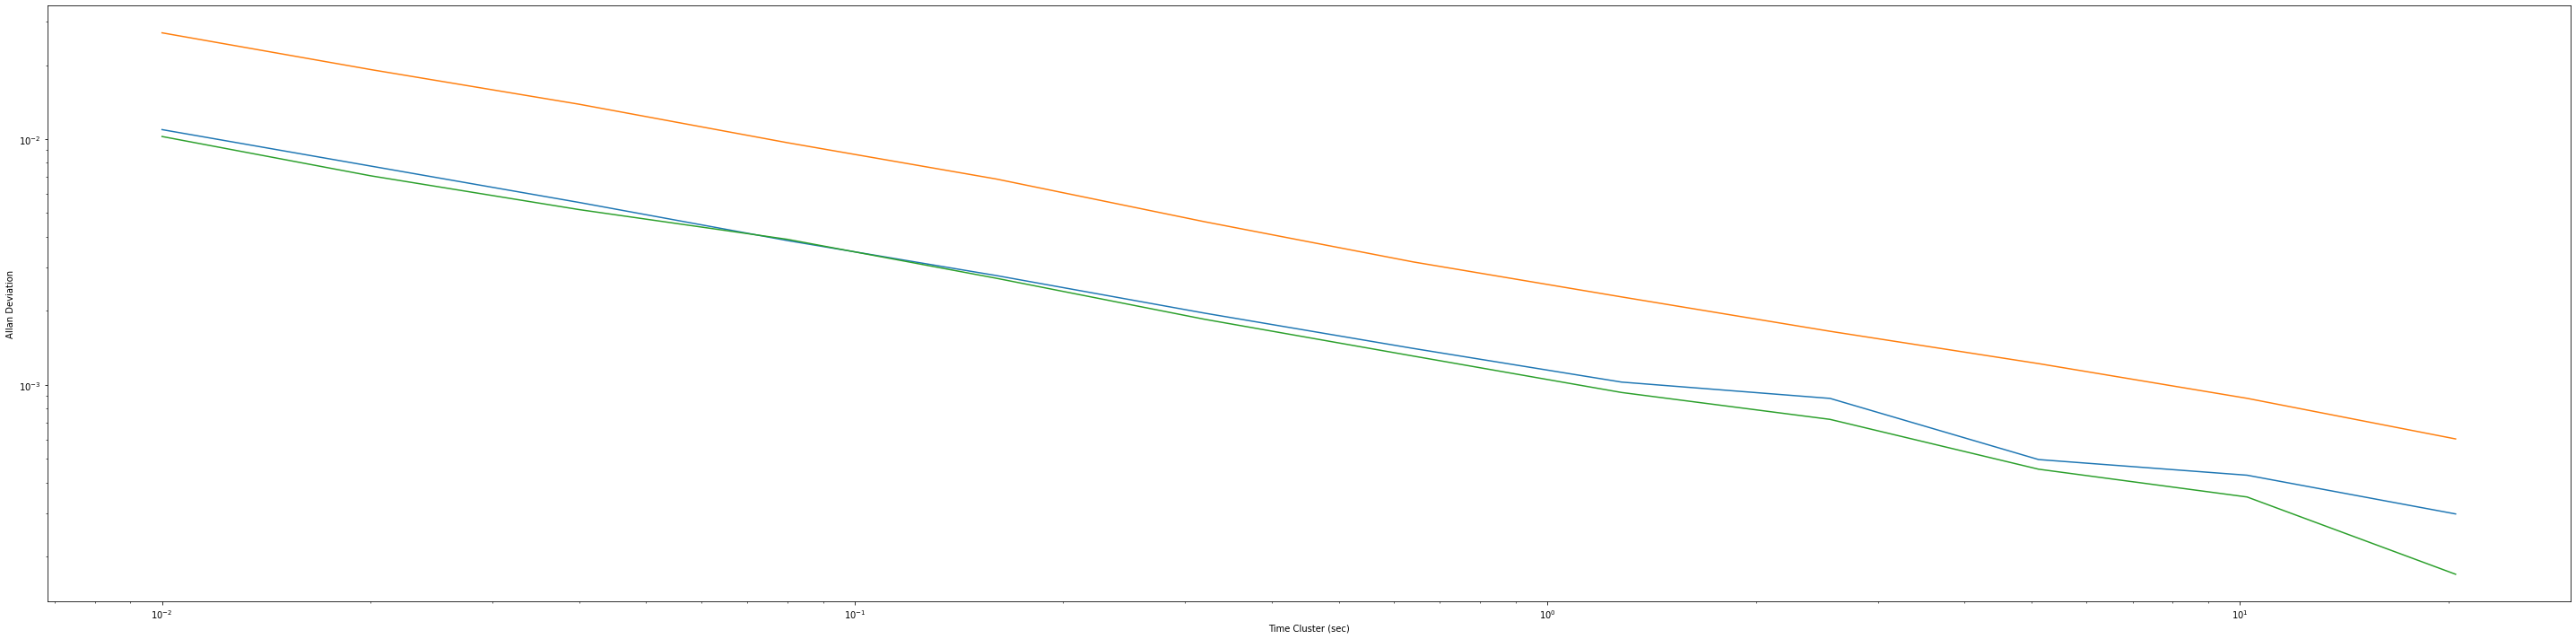

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import allantools

SAMPLES = 60000

plt.rcParams['figure.figsize'] = [40, 10]

(t2x, adx, adex, adnx) = allantools.oadev(np.array(avel_x_axis), rate=100, data_type="freq")
(t2y, ady, adey, adny) = allantools.oadev(np.array(avel_y_axis), rate=100, data_type="freq")
(t2z, adz, adez, adnz) = allantools.oadev(np.array(avel_z_axis), rate=100, data_type="freq")

plt.loglog(t2x,adx)
plt.loglog(t2y,ady)
plt.loglog(t2z,adz)
plt.xlabel('Time Cluster (sec)')
plt.ylabel('Allan Deviation')